In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
import boto3
import botocore.session
from boto3.s3.transfer import TransferConfig
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col, split, udf, \
                                  split, monotonically_increasing_id
from pyspark.ml.feature import StringIndexer
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StringType, ArrayType, DoubleType
import io
from PIL import Image
import numpy as np
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.feature import StandardScaler, PCA
from datetime import datetime
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Sets the Ipython options

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Tensorflow 2 = INFO and WARNING messages are not printed

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.applications.vgg16 import VGG16

<h1>Set UP

<h6>Spark Config

In [ ]:
# Retrieves given aws credentials 

session = botocore.session.get_session()
credentials = session.get_credentials()

# Applies necessary packages to pyspark to work

os.environ['PYSPARK_SUBMIT_ARGS'] = \
    '--packages com.amazonaws:aws-java-sdk-pom:1.12.249,org.apache.hadoop:hadoop-aws:3.3.1 pyspark-shell'

<h6> Tensorflow Model (VGG16)

In [ ]:
# Defines VGG16 model and sets parameters as non trainable
# NB : the model implements a max poolings as the ultimate layer 
# to use the model as a feature extraction "tool"

model = VGG16(weights="imagenet",
                     pooling='max', 
                     include_top=False,
                     input_shape=(224, 224, 3))

for layer in model.layers:
            layer.trainable = False

model.compile()
model.summary()

<h6>UDFs

In [ ]:
# Defines several UDFs functions

# Functions

def feature_extract(bytes_type):
    
    """Transforms a given picture in a 224*224 matrix"""

    lambda_list = np.asarray(Image.open(io.BytesIO(bytes_type)).resize((224,224)))
    
    vectorized = model.predict(np.array([lambda_list])).tolist()[0]
                             
    return vectorized

def extract_label(path):
    
    """Extracts fruit label from the image path"""
    
    splitted_list = re.split('/', path)
    
    return splitted_list[4]

# UDFs

feature_extract_UDF = udf(lambda x: feature_extract(x), ArrayType(DoubleType()))

to_vector_UDF = udf(lambda x: Vectors.dense(x), VectorUDT())

label_extract_UDF = udf(lambda path: extract_label(path), StringType())

<h1>Monitoring Loop

One have to run manualy as many time this script as it wants to try different number of workers e.g : local[1] local[2] etc.
Indeed, none of the following option spark.sparkContext.cancelAllJobs(), spark.stop(), spark.sparkContext.stop(), time.sleep(60) would allow to loop different number of workers in a single loop. 

In [ ]:
# Defines a SparkSession

workers = 4

spark = SparkSession \
        .builder\
        .appName("ETL Pipeline")\
        .master("local[{}]".format(workers))\
        .config("spark.hadoop.fs.s3a.access.key", credentials.access_key)\
        .config("spark.hadoop.fs.s3a.secret.key", credentials.secret_key)\
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")\
        .getOrCreate()

spark

In [ ]:
# Sets up a dataframe for result commits

log_df = pd.DataFrame(columns=['workers', 'images_size', 'dimentionality','time'])

In [ ]:
i = 0

# Loops in between buckets of different image sizes as the computation of a subset 
# of a Pyspark dataframe would lead to an action and therefore not leverage pyspark
# lazy evaluation interest

for image_size in [1000]:
    
    # Sets the S3 bucket path of images

    s3_object_path = 's3a://oc-projet-8-monitoring/Monitoring/{}/**'.format(image_size)
    
    # Retreives images from S3 bucket
    
    df = spark.read.format("binaryFile").load(s3_object_path)
    
    # Extracts the features from the images

    feature_extracted_df = df.select(feature_extract_UDF(df.content).alias("features"))
    
    # Transform the rows of the dataframe in dense vectors for further pyspark ml usage

    vector_df = feature_extracted_df.select(to_vector_UDF('features').alias('features'))

    # Sets up 2 pca (one for a run without standardisation and another with) 
    # and one standardisation for mlpipelines trials
    
    n_components = 150

    std = StandardScaler(inputCol="features", outputCol="scaled")
    pca = PCA(inputCol="scaled", outputCol="pca").setK(n_components)
    pca_only = PCA(inputCol="features", outputCol="pca").setK(n_components)

    # Loops in between PCA only and STD + PCA mlpipelines (to apprehend the impact -- 
    # in performance of the standardisation step)
    
    for stages_select in [[pca_only], [std, pca]]:
        
        i += 1

        # Sets up the Pipeline
        
        pipeline = Pipeline().setStages(stages_select)
        
        # Start to count the total time of the pipeline as Pyspark need some precomputation here
        
        start = datetime.now()

        # Applies the ml pipeline
        
        pca_df = pipeline.fit(vector_df).transform(vector_df)
        
        # Transforms the single output column in as many column as there are Pcs Dataframe

        pca_df_multiple_columns = pca_df.withColumn("pc", vector_to_array("pca"))\
                                          .select([col("pc")[i] for i in range(n_components)])
        
        # Retrieves the labels from the df 

        label_df = df.select(label_extract_UDF(df.path).alias("labels"))
        
        # Gives ids to both dataframes for further join

        pca_df_multiple_columns_id = \
            pca_df_multiple_columns.withColumn('id', monotonically_increasing_id())

        label_df_id = label_df.withColumn('id', monotonically_increasing_id())
        
        # Joins PCs dataframe with relative labels

        labeled_pca_df = label_df_id.join(pca_df_multiple_columns_id, on=['id'], how='inner').drop('id')
        
        # Write in a bucket the dataframe as a csv
        # N.B : coalesce(1) is implemented to have one csv as an output

        labeled_pca_df.coalesce(1)\
                   .write.mode('overwrite')\
                   .save("s3a://oc-project-8-pca-csv/monitoring", format='csv', header=True)
        
        # Stop the count of pipeline running time
        
        end = datetime.now()
        
        # Computes total pipeline running time
        
        total_time = end - start
        
        # Commits the informations ('workers', 'images_size', 'dimentionality','time') 
        # inside log_df
        
        log_df.loc[i, ['workers', 'images_size', 'dimentionality','time']] = \
            workers, image_size, stages_select, total_time

In [ ]:
# Displays the results

log_df

<h1>Monitoring Visualization

In [3]:
# Sets up design variables

# Sizes

title_size = 50
tick_size = 30
text_size = 30

In [4]:
# Retrieves monitoring logs from txt file and transforms it in Pandas dataframe

monitoring = pd.read_csv('./monitoring_logs.txt')

monitoring['Time'] = pd.to_datetime(monitoring['Time'])

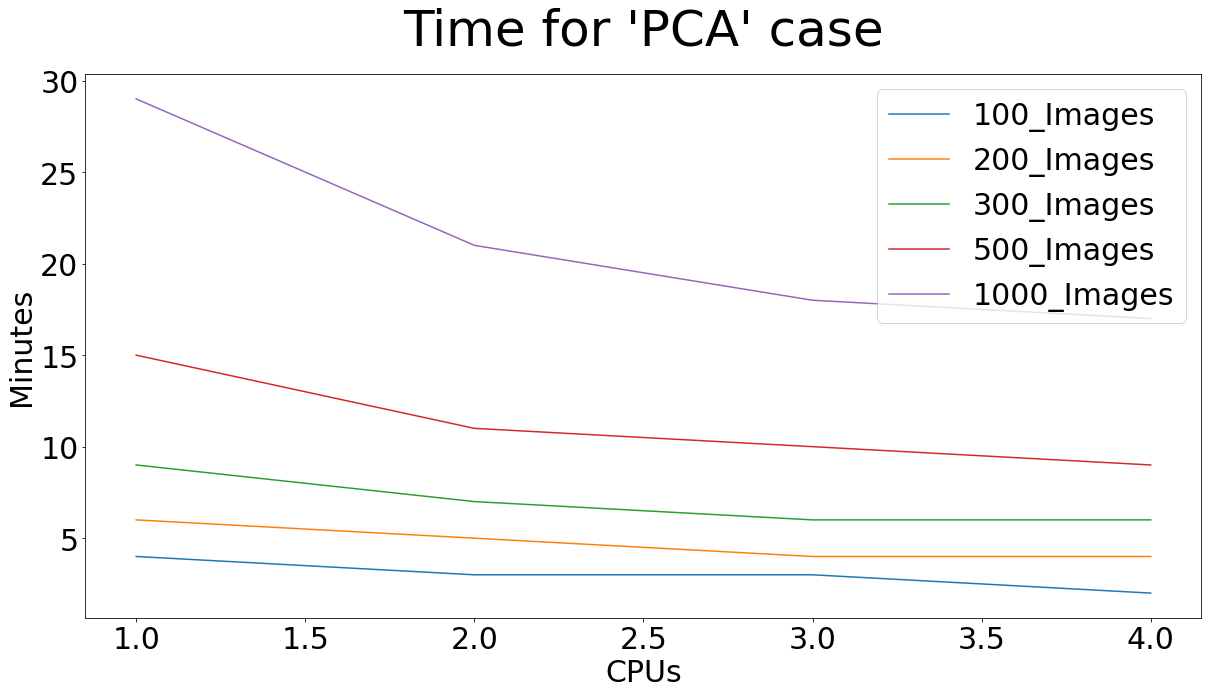

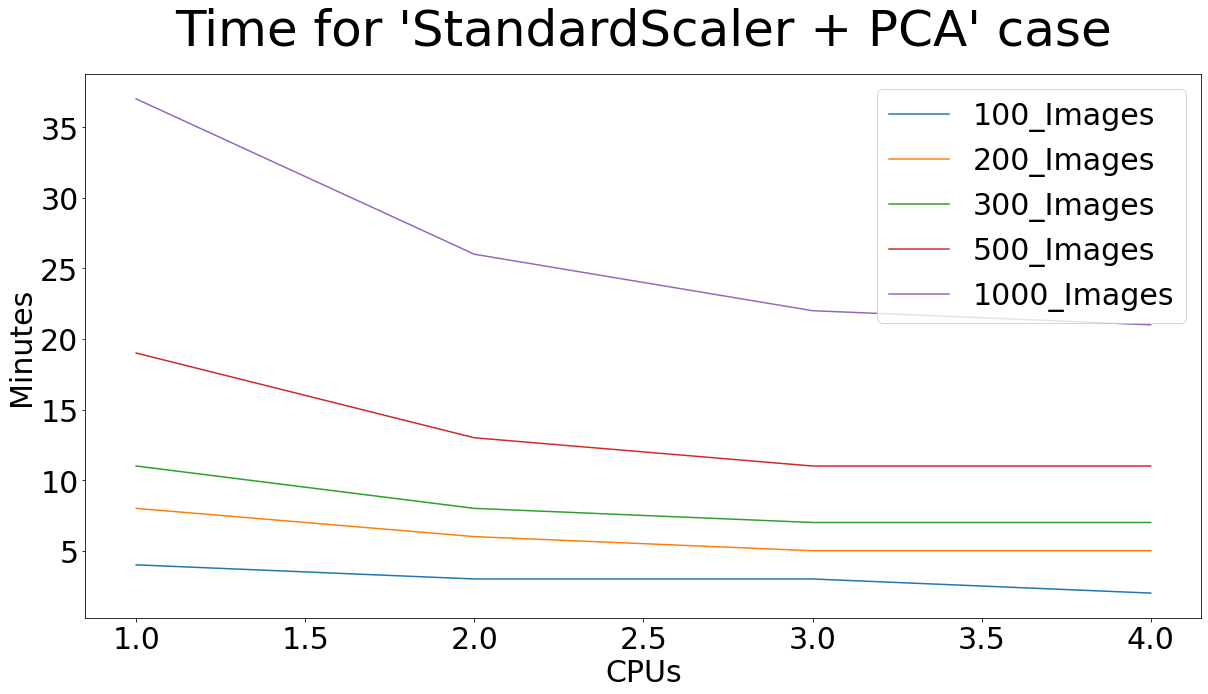

In [5]:
# Plots the pipelines running times 

for  i in monitoring['Transformation'].unique():
    
    fig, ax = plt.subplots(figsize=(20,10))
    
    for j in monitoring['Images'].unique():
        
    

        sns.lineplot(data=monitoring[(monitoring['Transformation'] == i)
                                     &(monitoring['Images'] == j)],
                     x='Workers', 
                     y=monitoring['Time'].dt.minute,
                     ax = ax)

        
    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel('CPUs', fontsize=text_size)
    ax.set_ylabel('Minutes', fontsize=text_size)
    plt.title('Time for ' + i +' case', pad=30, fontsize=title_size)
    plt.legend(labels=['100_Images','200_Images','300_Images', '500_Images', '1000_Images'], 
               prop={'size': text_size},
               loc='upper right')
    plt.show()

plt.show();